<a href="https://colab.research.google.com/github/ABeleris/EKPA/blob/main/tor_no_tor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

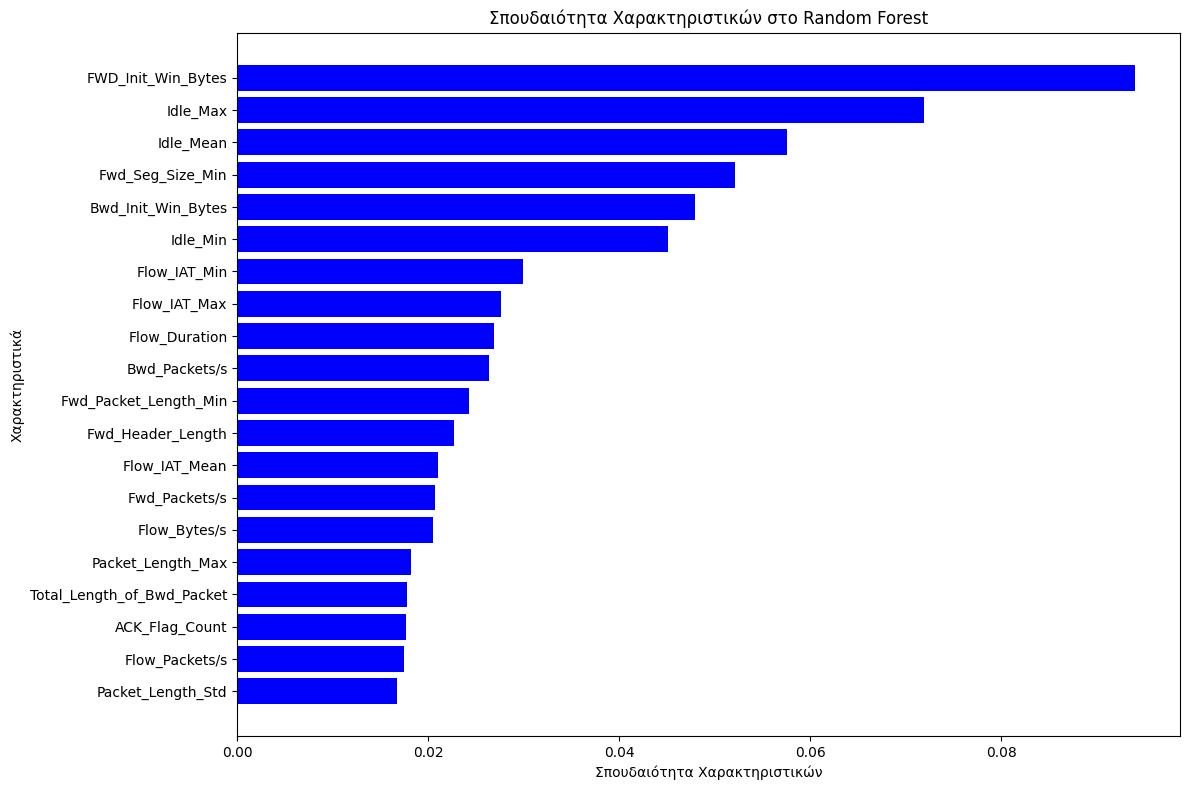

In [8]:
import pandas as pd  # για φόρτωση και επεξεργασία δεδομένων
import numpy as np  # για αριθμητικές πράξεις
from sklearn.model_selection import train_test_split  # Διαχωρισμός σε σύνολα εκπαίδευσης και δοκιμών
from sklearn.ensemble import RandomForestClassifier  # Μοντέλο Random Forest
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score  # Μέτρηση απόδοσης
import matplotlib.pyplot as plt  # Οπτικοποίηση
import seaborn as sns  # για διαγράμματα και ανάλυση δεδομένων

# Φόρτωση του dataset
url = "https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/DarkNet.csv"
df = pd.read_csv(url)

# Εξερεύνηση του dataset
print("Πρώτες γραμμές του dataset:")
print(df.head())  # Εμφανίζει τις πρώτες γραμμές του dataset

print("\nΣύνοψη δεδομένων:")
print(df.info())  # Πληροφορίες για τις στήλες και τους τύπους δεδομένων

print("\nΣτατιστική περιγραφή:")
print(df.describe())  # Στατιστικά στοιχεία για τις αριθμητικές στήλες

# Εναλλακτική Διερευνητική Ανάλυση Δεδομένων (EDA)
print("\nΔημιουργία γραφημάτων EDA...")
# Διανομή κατηγοριών της στήλης 'Label-1'
sns.countplot(x='Label-1', data=df)  # Διαγραμματικές τιμές της στήλης 'Label-1'
plt.title('Κατανομή Tor και Non-Tor Ετικετών')
plt.show()

# Έλεγχος για ανισορροπία στις κατηγορίες
label_counts = df['Label-1'].value_counts()
print("\nΚατανομή κατηγοριών:")
print(label_counts)
print("\nΑνάλυση Ανισορροπίας:")
if label_counts.min() / label_counts.max() < 0.5:
    print("Οι κατηγορίες είναι ανισοβαρείς, γεγονός που μπορεί να επηρεάσει την απόδοση του μοντέλου.")
else:
    print("Οι κατηγορίες είναι ισοβαρείς και το μοντέλο αναμένεται να αποδώσει καλά.")

# Έλεγχος κατανομών αριθμητικών χαρακτηριστικών
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols[:5]:  # Παράδειγμα: εμφάνιση 5 χαρακτηριστικών
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'Κατανομή για το χαρακτηριστικό: {col}')
    plt.show()

# Προεπεξεργασία δεδομένων
# Αφαίρεση μη χρήσιμων στηλών
columns_to_drop = ['Src_IP', 'Dst_IP', 'Src_Port', 'Dst_Port', 'Label-2']  # Μη σχετικές πληροφορίες
if set(columns_to_drop).issubset(df.columns):
    df = df.drop(columns=columns_to_drop, axis=1)

# Αντικατάσταση μη αριθμητικών τιμών
print("\nΕντοπισμός μη αριθμητικών τιμών:")
non_numeric_replacements = '?'  # Χρησιμοποιείται ως παράδειγμα μη αριθμητικών τιμών
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].replace(non_numeric_replacements, np.nan)  # Αντικατάσταση με NaN

# Έλεγχος για κενές τιμές
print("\nΚενές τιμές:")
print(df.isnull().sum())

# Αντικατάσταση κενών τιμών με τον μέσο όρο της στήλης
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].mean(), inplace=True)

# Εντοπισμός και διόρθωση ακραίων τιμών
print("\nΕντοπισμός ακραίων τιμών (Inf ή πολύ μεγάλες):")
for col in df.select_dtypes(include=[np.number]).columns:
    # Αντικατάσταση inf με NaN
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    # Αντικατάσταση NaN με μέση τιμή
    df[col].fillna(df[col].mean(), inplace=True)

# Διαχωρισμός χαρακτηριστικών (X) και ετικέτας (y)
X = df.drop('Label-1', axis=1)  # Όλα τα χαρακτηριστικά εκτός της ετικέτας
y = df['Label-1']  # Η ετικέτα (Tor ή Non-Tor)

# Επανέλεγχος για μη έγκυρες τιμές πριν την κανονικοποίηση
print("\nΕπανέλεγχος μη έγκυρων τιμών (NaN, Inf) στο X:")
print(X.isnull().sum())
print({col: np.isinf(X[col].values).sum() for col in X.select_dtypes(include=[np.number]).columns})

# Αφαίρεση μη έγκυρων τιμών σε συγχρονισμό με y
valid_indices = ~X.isin([np.nan, np.inf, -np.inf]).any(axis=1)  # Διατήρηση μόνο έγκυρων γραμμών
X = X.loc[valid_indices]
y = y.loc[valid_indices]

# Κανονικοποίηση αριθμητικών δεδομένων
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Πριν από το scaling, αντικατάσταση των υπόλοιπων inf με έναν μεγάλο πεπερασμένο αριθμό
# Μετατροπή όλων των στηλών σε αριθμητικές και τυχόν σφάλματα να αντικατασταθούν με NaN
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Αντικατάσταση inf με την μέγιστη πεπερασμένη τιμή σε κάθε στήλη
for col in X.select_dtypes(include=[np.number]).columns:
    max_finite = X[col][np.isfinite(X[col])].max()
    X[col] = X[col].replace([np.inf, -np.inf], max_finite)

# Συμπλήρωση τυχόν NaN απο τα παραπάνω
X.fillna(X.mean(), inplace=True)

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Διαχωρισμός σε σύνολο εκπαίδευσης και δοκιμών
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 80-20 split

# Δημιουργία και εκπαίδευση του μοντέλου
rf_model = RandomForestClassifier(random_state=42)  # Αρχικοποίηση του Random Forest Classifier
rf_model.fit(X_train, y_train)  # Εκπαίδευση με τα δεδομένα εκπαίδευσης

# Πρόβλεψη στο σύνολο δοκιμών
y_pred = rf_model.predict(X_test)

# Αξιολόγηση του μοντέλου
print("\nΑποτελέσματα Αξιολόγησης:")
print(classification_report(y_test, y_pred))

# Ακρίβεια του μοντέλου
# Ακρίβεια και άλλες μετρικές αξιολόγησης
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Ακρίβεια: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

# Σπουδαιότητα χαρακτηριστικών
feature_importances = rf_model.feature_importances_  # Σπουδαιότητα χαρακτηριστικών
features = X.columns

# Φιλτράρισμα χαρακτηριστικών με μηδενική σημαντικότητα
non_zero_indices = feature_importances > 0
filtered_features = features[non_zero_indices]
filtered_importances = feature_importances[non_zero_indices]

# Επιλογή των 20 πιο σημαντικών χαρακτηριστικών
top_20_indices = np.argsort(filtered_importances)[-20:]
filtered_features_top_20 = filtered_features[top_20_indices]
filtered_importances_top_20 = filtered_importances[top_20_indices]

# Οπτικοποίηση της σημαντικότητας χαρακτηριστικών
plt.figure(figsize=(12, 8))
plt.barh(filtered_features_top_20, filtered_importances_top_20, color='blue')  # Οπτικοποίηση με ταξινομημένα χαρακτηριστικά
plt.xlabel('Σπουδαιότητα Χαρακτηριστικών')
plt.ylabel('Χαρακτηριστικά')
plt.title('Σπουδαιότητα Χαρακτηριστικών στο Random Forest')
plt.tight_layout()
plt.show()